In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import argparse
import random
import os
import cv2
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19,VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
 
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)
print("GPU", "available (True)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.8.0
TF Hub version: 0.12.0
GPU available (True)


In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
fid = drive.ListFile({'q':"title='imagecovid.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('imagecovid.zip')

In [6]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [7]:
!unzip imagecovid.zip

Streaming output truncated to the last 5000 lines.
  inflating: imagecovid/Normal/Normal-1929.png  
  inflating: imagecovid/Normal/Normal-193.png  
  inflating: imagecovid/Normal/Normal-1930.png  
  inflating: imagecovid/Normal/Normal-1931.png  
  inflating: imagecovid/Normal/Normal-1932.png  
  inflating: imagecovid/Normal/Normal-1933.png  
  inflating: imagecovid/Normal/Normal-1934.png  
  inflating: imagecovid/Normal/Normal-1935.png  
  inflating: imagecovid/Normal/Normal-1936.png  
  inflating: imagecovid/Normal/Normal-1937.png  
  inflating: imagecovid/Normal/Normal-1938.png  
  inflating: imagecovid/Normal/Normal-1939.png  
  inflating: imagecovid/Normal/Normal-194.png  
  inflating: imagecovid/Normal/Normal-1940.png  
  inflating: imagecovid/Normal/Normal-1941.png  
  inflating: imagecovid/Normal/Normal-1942.png  
  inflating: imagecovid/Normal/Normal-1943.png  
  inflating: imagecovid/Normal/Normal-1944.png  
  inflating: imagecovid/Normal/Normal-1945.png  
  inflating: imageco

In [8]:
PATH= '/content/imagecovid'

In [9]:
COVID_PATH = '/content/imagecovid/Covid/'
NORMAL_PATH = '/content/imagecovid/Normal/'
PNEUMONIA_PATH = '/content/imagecovid/Pneomonia'

In [10]:
import pandas as pd
import numpy as np
import os
from glob import glob
import random
import matplotlib.pylab as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

In [11]:
#Data Preprocessing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
import cv2

In [12]:
#Model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import PrecisionAtRecall,Recall

In [13]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [15]:
from numpy.random import seed
seed(0)

In [16]:
def img_preprocessing(image_path):
    img = cv2.imread(image_path, 0)
    org_img = img.copy()
    brightest = np.max(img)
    darkest = np.min(img)
    T = darkest + 0.9*(brightest - darkest)
    thre_img = cv2.threshold(img, T, 255, cv2.THRESH_BINARY)
    thre_img = thre_img[1]
    kernel = np.ones((5, 5), np.uint8)
    cleaned = cv2.erode(thre_img, kernel, iterations = 5)
    cleaned = cv2.dilate(cleaned, kernel, iterations = 5)
    cleaned = cleaned//255
    img = img * cleaned
    img = org_img - img
    dim = (224, 224)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    B = cv2.bilateralFilter(img, 9, 75, 75)
    R = cv2.equalizeHist(img)
    new_img = cv2.merge((B, img, R))
    return new_img

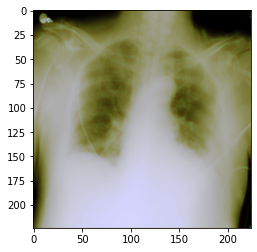

In [17]:
img = img_preprocessing(COVID_PATH + '/COVID-1.png')
plt.imshow(img)

In [18]:
base_dir = 'base_dir'
os.mkdir(base_dir)
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
COVID = os.path.join(train_dir, 'COVID')
os.mkdir(COVID)
Viral_Pneumonia = os.path.join(train_dir, 'Viral_Pneumonia')
os.mkdir(Viral_Pneumonia)
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
COVID = os.path.join(val_dir, 'COVID')
os.mkdir(COVID)
Viral_Pneumonia = os.path.join(val_dir, 'Viral_Pneumonia')
os.mkdir(Viral_Pneumonia)
Normal = os.path.join(test_dir, 'Normal')
os.mkdir(Normal)
COVID = os.path.join(test_dir, 'COVID')
os.mkdir(COVID)
Viral_Pneumonia = os.path.join(test_dir, 'Viral_Pneumonia')
os.mkdir(Viral_Pneumonia)

In [19]:
import numpy as np
from sklearn.utils import shuffle

In [20]:
folder_1 = os.listdir(COVID_PATH)
folder_1 = shuffle(folder_1)
folder_2 = os.listdir(NORMAL_PATH)
folder_2 = shuffle(folder_2)
folder_3 = os.listdir(PNEUMONIA_PATH)
folder_3 = shuffle(folder_3)

In [21]:
covid_data = pd.DataFrame(folder_1, columns = ['FILE NAME'])
normal_data = pd.DataFrame(folder_2, columns = ['FILE NAME'])
pneumonia_data = pd.DataFrame(folder_3, columns = ['FILE NAME'])
covid_data['Target'] = 'COVID'
normal_data['Target'] = 'Normal'
pneumonia_data['Target'] = 'Viral_Pneumonia'
covid_data['Labels'] = '0'
normal_data['Labels'] = '1'
pneumonia_data['Labels'] = '2'
data = pd.concat([covid_data, normal_data, pneumonia_data], axis = 0, sort = False)
data

,FILE NAME,Target,Labels
0,COVID-2339.png,COVID,0
1,COVID-2057.png,COVID,0
2,COVID-275.png,COVID,0
3,COVID-861.png,COVID,0
4,COVID-617.png,COVID,0
...,...,...,...
3011,person1147_virus_1920.jpeg,Viral_Pneumonia,2
3012,person569_virus_1110.jpeg,Viral_Pneumonia,2
3013,person1050_bacteria_2984.jpeg,Viral_Pneumonia,2
3014,person445_virus_918.jpeg,Viral_Pneumonia,2


In [22]:
covid_data = pd.DataFrame(folder_1, columns = ['FILE NAME'])
normal_data = pd.DataFrame(folder_2, columns = ['FILE NAME'])
pneumonia_data = pd.DataFrame(folder_3, columns = ['FILE NAME'])
covid_data['Target'] = 'COVID'
normal_data['Target'] = 'Normal'
pneumonia_data['Target'] = 'Viral_Pneumonia'
covid_data['Labels'] = '0'
normal_data['Labels'] = '1'
pneumonia_data['Labels'] = '2'
data = pd.concat([covid_data, normal_data, pneumonia_data], axis = 0, sort = False)
data

,FILE NAME,Target,Labels
0,COVID-2339.png,COVID,0
1,COVID-2057.png,COVID,0
2,COVID-275.png,COVID,0
3,COVID-861.png,COVID,0
4,COVID-617.png,COVID,0
...,...,...,...
3011,person1147_virus_1920.jpeg,Viral_Pneumonia,2
3012,person569_virus_1110.jpeg,Viral_Pneumonia,2
3013,person1050_bacteria_2984.jpeg,Viral_Pneumonia,2
3014,person445_virus_918.jpeg,Viral_Pneumonia,2


In [23]:
y1 = data['Labels']
df_train, df_val_test = train_test_split(data, test_size=0.3, random_state=101, stratify = y1)
y2 = df_val_test['Labels']
df_val, df_test = train_test_split(df_val_test, test_size=0.5, random_state=101, stratify = y2)
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)
df_train[100:120]

(6333, 3)
(1357, 3)
(1358, 3)


,FILE NAME,Target,Labels
651,COVID-526.png,COVID,0
1602,COVID-2640.png,COVID,0
2954,Normal-2152.png,Normal,1
800,Normal-2611.png,Normal,1
1569,COVID-809.png,COVID,0
2021,person1065_virus_1768.jpeg,Viral_Pneumonia,2
2561,COVID-1345.png,COVID,0
2902,Normal-1874.png,Normal,1
86,Normal-699.png,Normal,1
2775,COVID-644.png,COVID,0


In [24]:
data.set_index('FILE NAME', inplace = True)
data

,Target,Labels
FILE NAME,,
COVID-2339.png,COVID,0
COVID-2057.png,COVID,0
COVID-275.png,COVID,0
COVID-861.png,COVID,0
COVID-617.png,COVID,0
...,...,...
person1147_virus_1920.jpeg,Viral_Pneumonia,2
person569_virus_1110.jpeg,Viral_Pneumonia,2
person1050_bacteria_2984.jpeg,Viral_Pneumonia,2


In [25]:
data.tail()

,Target,Labels
FILE NAME,,
person1147_virus_1920.jpeg,Viral_Pneumonia,2
person569_virus_1110.jpeg,Viral_Pneumonia,2
person1050_bacteria_2984.jpeg,Viral_Pneumonia,2
person445_virus_918.jpeg,Viral_Pneumonia,2
person253_bacteria_1156.jpeg,Viral_Pneumonia,2


In [26]:
# Get a list of train and val images
train_list = list(df_train['FILE NAME'])
val_list = list(df_val['FILE NAME'])
test_list = list(df_val['FILE NAME'])

In [27]:
# Transfer the train images

for image in train_list:
    fname = image
    label = data.loc[image,'Target']
    if fname in folder_1:
        src = os.path.join(COVID_PATH, fname)
        dst = os.path.join(train_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)

for image in val_list:
    fname = image
    label = data.loc[image,'Target']
    if fname in folder_1:
        src = os.path.join(COVID_PATH, fname)
        dst = os.path.join(val_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)
        
for image in test_list:
    fname = image 
    label = data.loc[image,'Target']
    if fname in folder_1:
        src = os.path.join(COVID_PATH, fname)
        dst = os.path.join(test_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)

In [28]:
for image in train_list:

    fname = image
    label = data.loc[image,'Target']
    if fname in folder_2:
        src = os.path.join(NORMAL_PATH, fname)
        dst = os.path.join(train_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)

for image in val_list:
    fname = image
    label = data.loc[image,'Target']
    if fname in folder_2:
        src = os.path.join(NORMAL_PATH, fname)
        dst = os.path.join(val_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)
        
for image in test_list:
    fname = image 
    label = data.loc[image,'Target']
    if fname in folder_2:
        src = os.path.join(NORMAL_PATH, fname)
        dst = os.path.join(test_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)

In [29]:
for image in train_list:
    fname = image
    label = data.loc[image,'Target']
    if fname in folder_3:
        src = os.path.join(PNEUMONIA_PATH, fname)
        dst = os.path.join(train_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)

for image in val_list:
    fname = image 
    label = data.loc[image,'Target']
    if fname in folder_3:
        src = os.path.join(PNEUMONIA_PATH, fname)
        dst = os.path.join(val_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)
        
for image in test_list:
    fname = image 
    label = data.loc[image,'Target']
    if fname in folder_3:
        src = os.path.join(PNEUMONIA_PATH, fname)
        dst = os.path.join(test_dir, label, fname)
        image = img_preprocessing(src)
        cv2.imwrite(dst, image)

In [30]:
print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/COVID')))
print(len(os.listdir('base_dir/val_dir/COVID')))
print(len(os.listdir('base_dir/train_dir/Viral_Pneumonia')))
print(len(os.listdir('base_dir/val_dir/Viral_Pneumonia')))

2111
452
2111
452
2111
453


In [31]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = 'base_dir/test_dir'

In [32]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [33]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=32,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=32,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=32,
                                        class_mode='categorical', shuffle=False)

Found 6333 images belonging to 3 classes.
Found 1357 images belonging to 3 classes.
Found 1357 images belonging to 3 classes.


In [34]:
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.layers import *
from keras.models import *
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from keras.applications.densenet import DenseNet121

import numpy as np # linear algebra
import pandas as pd
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=100)
mc = ModelCheckpoint("own.h5", monitor='val_loss',save_best_only=True, mode='min',verbose=1)

In [35]:
epochs = 100
stepsperepoch=9
validationsteps=1

In [36]:
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.optimizers import SGD, Adam, Adamax
from tensorflow.keras import Model
import tensorflow as tf

In [37]:
input_t = Input(shape=(224, 224, 3))

In [38]:

model = tf.keras.models.Sequential([
      layers.BatchNormalization(),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.3),
      layers.Conv2D(128,3,activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(256, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.3),
      layers.Conv2D(512, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(1024, activation='relu'),
      layers.Dropout(0.15),
      layers.Dense(3, activation= 'softmax')
    ])

In [39]:
model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
hist = model.fit_generator(
    train_gen,
    epochs=epochs,
    callbacks=[annealer,mc,es],
    steps_per_epoch=stepsperepoch,
    validation_data=val_gen,
    validation_steps = validationsteps
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 26.2814 - accuracy: 0.4236
Epoch 1: val_loss improved from inf to 1.09811, saving model to own.h5
9/9 [==============================] - 8s 494ms/step - loss: 26.2814 - accuracy: 0.4236 - val_loss: 1.0981 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.7826 - accuracy: 0.6701
Epoch 2: val_loss improved from 1.09811 to 1.09027, saving model to own.h5
9/9 [==============================] - 4s 441ms/step - loss: 0.7826 - accuracy: 0.6701 - val_loss: 1.0903 - val_accuracy: 0.3750 - lr: 9.5000e-04
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.7083
Epoch 3: val_loss improved from 1.09027 to 1.03290, saving model to own.h5
9/9 [==============================] - 4s 445ms/step - loss: 0.6575 - accuracy: 0.7083 - val_loss: 1.0329 - val_accuracy: 0.6562 - lr: 9.0250e-04
Epoch 4/100
9/9 [==============================] - ETA: 0s - los

In [41]:
preds = model.evaluate(val_gen)
print ("Validation Loss = " + str(preds[0]))
print ("Validation Accuracy = " + str(preds[1]))

43/43 [==============================] - 4s 91ms/step - loss: 0.2914 - accuracy: 0.8887
Validation Loss = 0.2914073169231415
Validation Accuracy = 0.8887251019477844


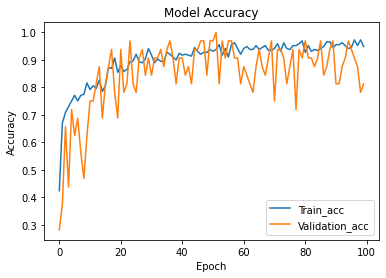

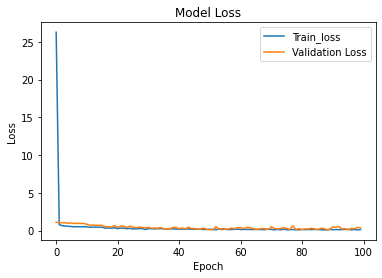

In [42]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Train_acc","Validation_acc"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Train_loss","Validation Loss"])
plt.show()

In [43]:
test_accu = model.evaluate(
test_gen)
print('The testing accuracy is :',test_accu[1]*100, '%')

43/43 [==============================] - 4s 100ms/step - loss: 0.2914 - accuracy: 0.8887
The testing accuracy is : 88.87251019477844 %


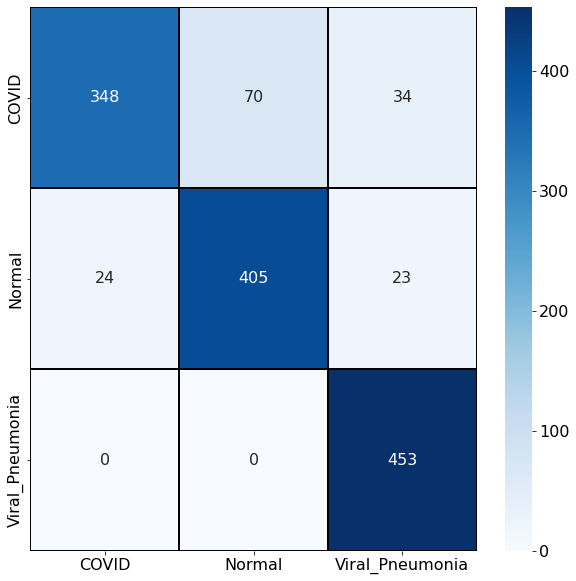

In [44]:
from sklearn.metrics import confusion_matrix
plt.rcParams.update({'font.size': 16})
predictions = model.predict(test_gen)
predictions = np.argmax(predictions,axis=1)
predictions[:15]
cm = confusion_matrix(test_gen.classes, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2'], columns = ['0', '1', '2'])
cm
class_names = ['COVID','Normal','Viral_Pneumonia']

def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

In [45]:
#confusion matrx 
y_pred = model.predict_generator(test_gen, steps=len(test_gen), verbose=1)
y_pred = y_pred.argmax(axis=-1)
y_true = test_gen.classes
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

 1/43 [..............................] - ETA: 4s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


43/43 [==============================] - 3s 80ms/step


Confusion Matrix without Normalization


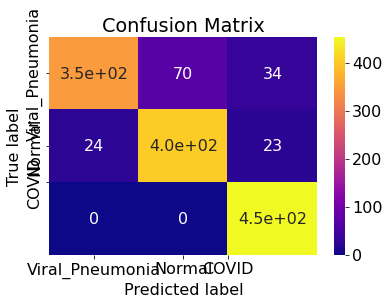

In [46]:
import seaborn as sns

def plot_confusion_matrix(normalize):
  classes = ['Viral_Pneumonia','Normal','COVID']
  tick_marks = [0.5,1.5,2.0]
  confusion = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize=None)
  sns.heatmap(confusion,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  #plt.savefig('/content/drive/My Drive/deep learning projects/covid19/keras-covid-19/vgg_chest_confusion.png')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

In [47]:
#Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.77      0.84       452
           1       0.85      0.90      0.87       452
           2       0.89      1.00      0.94       453

    accuracy                           0.89      1357
   macro avg       0.89      0.89      0.89      1357
weighted avg       0.89      0.89      0.89      1357



In [48]:

#Let's plot ROC & AUC
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
all_labels = ['COVID-19','NORMAL','Viral_Pneumonia']

0.9165014504799621

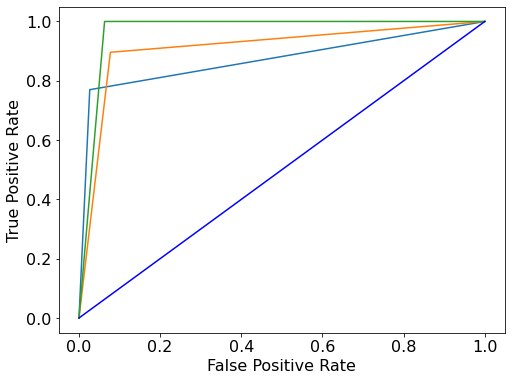

In [49]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (8, 6))

def multiclass_roc_auc_score(y_true, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_test = lb.transform(y_true)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
#true_concat.reset() # resetting generator
# y_pred = model.predict_generator(y_test, verbose = True)
# y_pred = np.argmax(y_pred, axis=1)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
multiclass_roc_auc_score(y_true, y_pred)

In [50]:
fid = drive.ListFile({'q':"title='Unseen_data.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Unseen_data.zip')

In [51]:
!unzip Unseen_data.zip

Archive:  Unseen_data.zip
   creating: Unseen_data/Covid/
  inflating: Unseen_data/Covid/1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg  
  inflating: Unseen_data/Covid/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg  
  inflating: Unseen_data/Covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: Unseen_data/Covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: Unseen_data/Covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: Unseen_data/Covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: Unseen_data/Covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: Unseen_data/Covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: Unseen_data/Covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: Unseen_data/Covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: Unseen_data/Covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: Unseen_data/Covid/1-s2.0-S1684118220300682-main.pdf-003-b2.png  
  inflating: Unseen_data/Covid/23E99E2E-44

Normal Test (10 0ut of 4)

In [52]:
from keras.preprocessing import image

def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)
  img = np.expand_dims(img , axis= 0 )
  
  return img

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



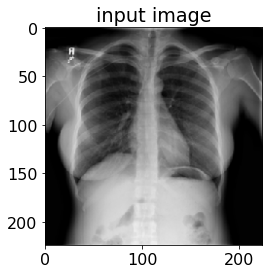

In [53]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10191.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



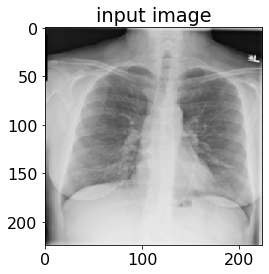

In [54]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10172.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



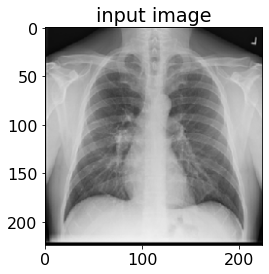

In [55]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10173.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



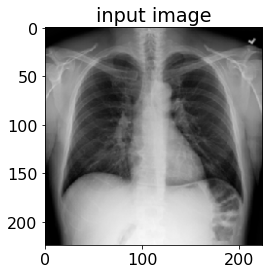

In [56]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10174.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



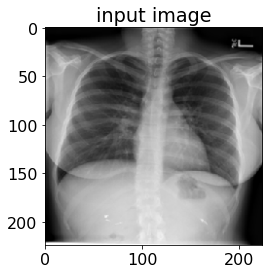

In [57]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10183.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



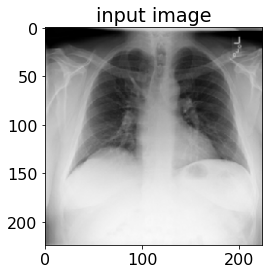

In [58]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10179.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 9.714712350252519e-32 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



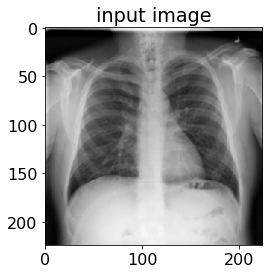

In [59]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10192.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



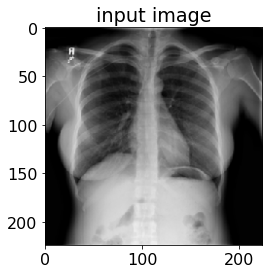

In [60]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10191.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



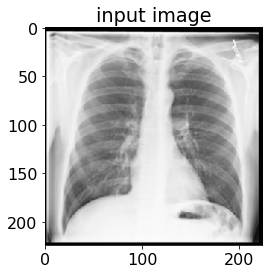

In [61]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10190.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = NORMAL

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 100.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



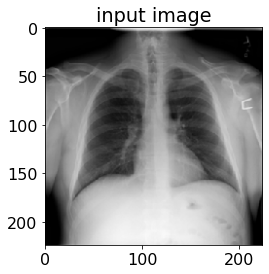

In [62]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Normal/Normal-10189.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

#Pneumonia(out10 of 8 none)

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



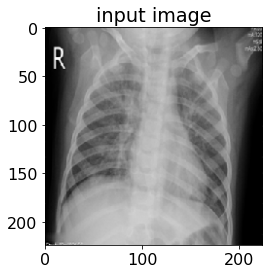

In [63]:
# path for that new image. ( you can take it either from google or any other scource)

path = '/content/Unseen_data/Pnemonia/Viral Pneumonia-1.png'    # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



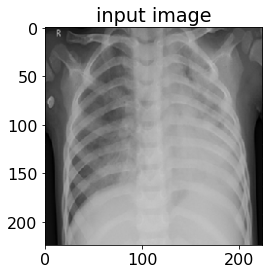

In [64]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Pnemonia/Viral Pneumonia-10.png"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0834078702609986 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 99.91658926010132 percent



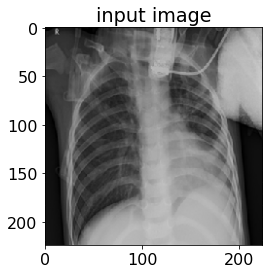

In [65]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Pnemonia/Viral Pneumonia-11.png"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



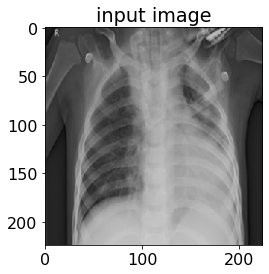

In [66]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Pnemonia/Viral Pneumonia-14.png"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



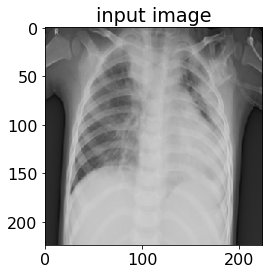

In [67]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Pnemonia/Viral Pneumonia-13.png"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 1.0417367294331807e-29 percent



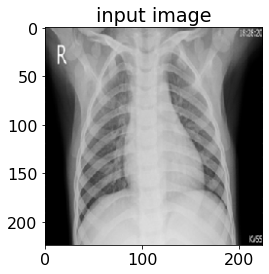

In [68]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Pnemonia/Viral Pneumonia-2.png"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



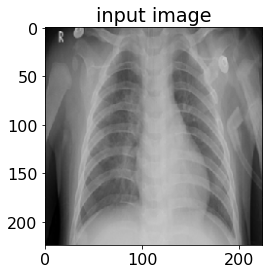

In [69]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Pnemonia/Viral Pneumonia-20.png"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0007899984666437376 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 99.99921321868896 percent



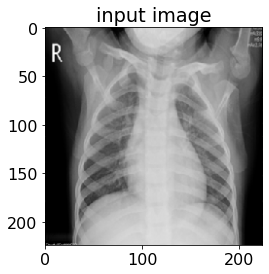

In [70]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Pnemonia/Viral Pneumonia-3.png"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



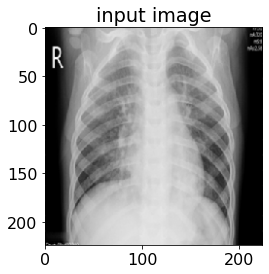

In [71]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Pnemonia/Viral Pneumonia-4.png"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = Viral_Pneumonia

The chances of image being Covid is : 0.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 100.0 percent



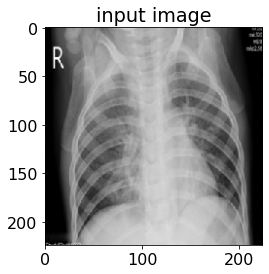

In [72]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Pnemonia/Viral Pneumonia-5.png"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

Covid (out of 10, 10 identified )

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



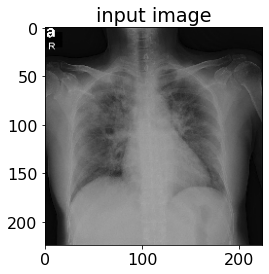

In [73]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

#Covid(10,10)

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



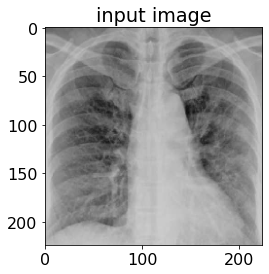

In [74]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Covid/1-s2.0-S1684118220300608-main.pdf-001.jpg"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



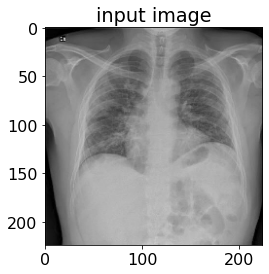

In [75]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Covid/1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



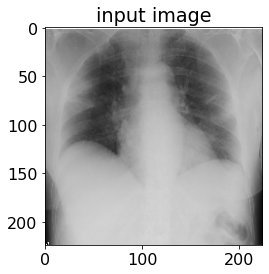

In [76]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Covid/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



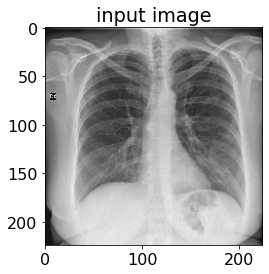

In [77]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Covid/23E99E2E-447C-46E5-8EB2-D35D12473C39.png"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



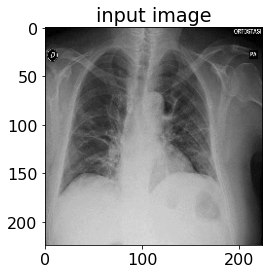

In [78]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Covid/2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



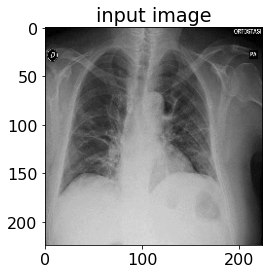

In [79]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Covid/2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



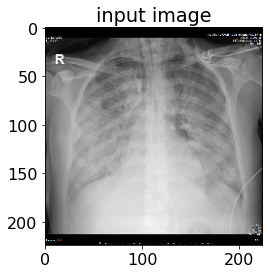

In [80]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Covid/31BA3780-2323-493F-8AED-62081B9C383B.jpeg"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



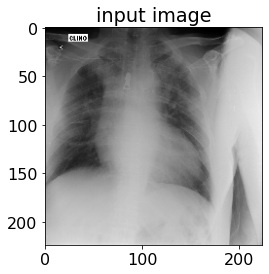

In [81]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Covid/7AF6C1AF-D249-4BD2-8C26-449304105D03.jpeg"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

The given X-Ray image is of type = COVID-19

The chances of image being Covid is : 100.0 percent

The chances of image being Normal is : 0.0 percent

The chances of image being Viral_Pneumonia is : 0.0 percent



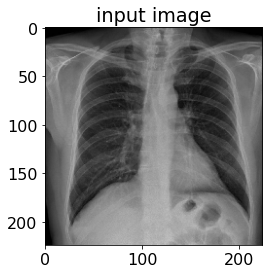

In [82]:
# path for that new image. ( you can take it either from google or any other scource)

path = "/content/Unseen_data/Covid/7C69C012-7479-493F-8722-ABC29C60A2DD.jpeg"     # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = all_labels[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")
print()
print(f"The chances of image being Viral_Pneumonia is : {model.predict(img)[0][2]*100} percent")
print()

# to display the image  
plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()